# Lab0. Prerequisite-Prepare license plate image and annotation data

In this lab, you will generate 10,000 Korean lincense plate images with annotations for training.  
Before running, 
* **Maker sure you have enough local storage to store traing images (2+GB)**
* You may adjust the number of image to 1,000, 5,000, etc. for more fast processing
* You may adjust the number of image to 50,000, 100,000, etc. for more accuracy

You can run all notebook cells at once.  
Image generation and processing script was quoted from ([here](https://github.com/matthewearl/deep-anpr))

## Set up dependencies

In [1]:
import sys
!{sys.executable} -m pip install opencv-python image matplotlib 

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.


In [2]:
from PIL import Image
import os

## Download background images
- **It may take 2~3 minutes** to download and extract images
- SUN dataset(https://vision.princeton.edu/projects/2010/SUN/) were used

In [3]:
if os.path.exists('bgs')==False:
    !wget https://s3.ap-northeast-2.amazonaws.com/leon-shared/bgs/bgs-reduced.zip -O /tmp/bgs-reduced.zip
    !unzip /tmp/bgs-reduced.zip |wc -l
    !rm /tmp/bgs-reduced.zip
bgs = os.listdir('bgs')
print("{} images were downloaded.".format(len(bgs)))

30000 images were downloaded.


In [4]:
!rm -fR gen gen-imgs gen-tags cropped-imgs nums-tags
!mkdir gen gen/gen-imgs gen/gen-tags gen/cropped-imgs gen/nums-tags
!chmod 755 gen-w-bbx.py

## Generate training images and tags
* Execute gen-w-bbx.py as the argument of 10,000 number of sample images (You can change the number of sample images)
* This code will generate 10,000 Korean license plate sample images in following folders
    * gen/gen-imgs: Arbitrary Korean license plate images
    * gen/gen-tags: The position(cordinates) of license plate in the image
    * gen/cropped-imgs: License-plate-cropped images from generated trining imaged
    * gen/nums-tags: Json files to record the character of license plate as list
* **It may take 1 minutes** if you generate 100,000 images
* **It may take 10+ minutes if you generate 100,000+ images**

In [5]:
num_of_images = 10000 #Set the number of images as 10000 or 1000~1000000 
assert num_of_images != None

In [6]:
%run gen-w-bbx.py {num_of_images}

00000000_JA61D_0
00000001_YVMLWHP_1
00000002_8LW_1
00000003_BN4K8I_0
00000004_Z1JM39_1
00000005_JWO0K_1
00000006_HJCLS_1
00000007_M7EY_1
00000008_57KPSC_0
00000009_AR9_0
... 10000 images and tags were generated


## Check the result of data generation

* Define bounding box visualization function

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
def visualize_detection(img_file, dets, code, thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.image as mpimg

        img=img_file
        plt.imshow(img)
        height = img.size[0]
        width = img.size[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = x0
            ymin = y0
            xmax = x1
            ymax = y1
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(code, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

* Check the number of images

In [8]:
print(len(os.listdir('gen/gen-imgs')))
print(len(os.listdir('gen/cropped-imgs')))

10000
10000


* Check **10 sample images** with annotations(as bounding box) and cropped images

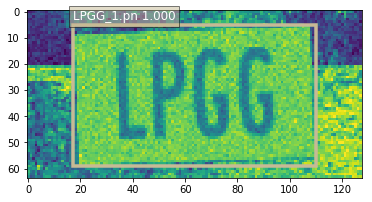

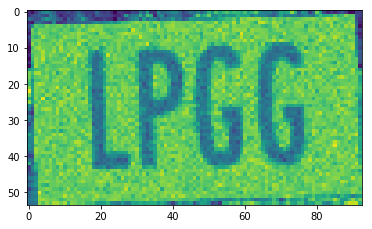

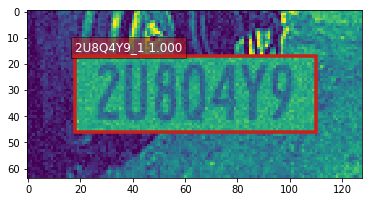

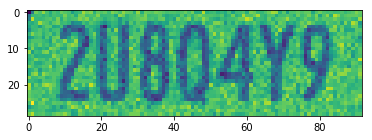

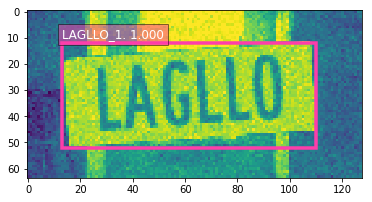

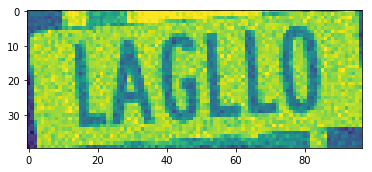

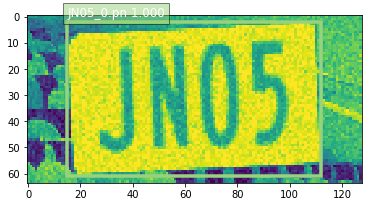

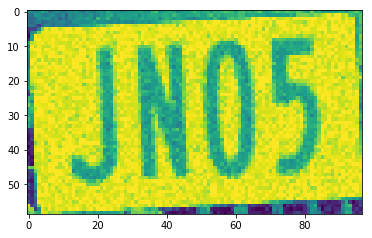

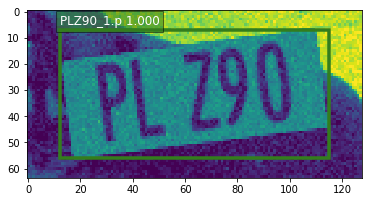

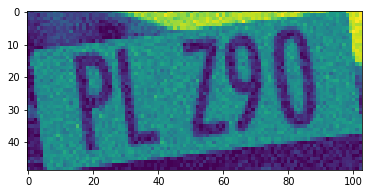

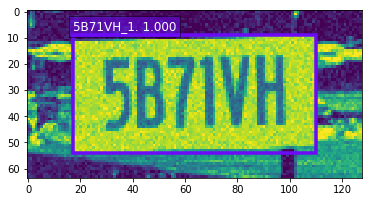

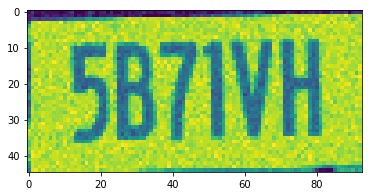

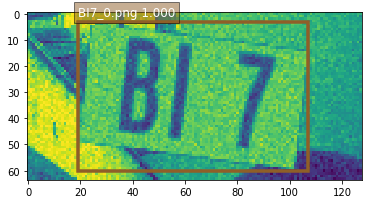

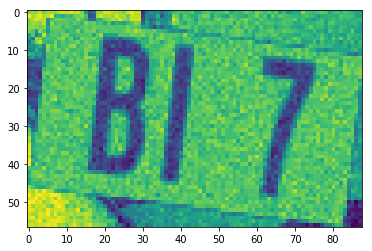

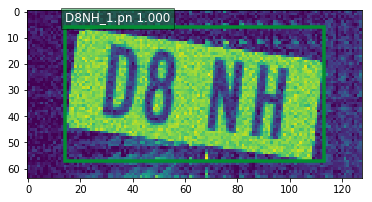

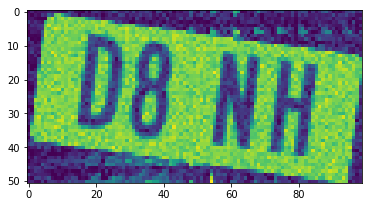

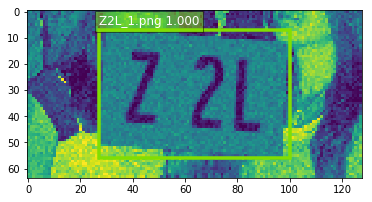

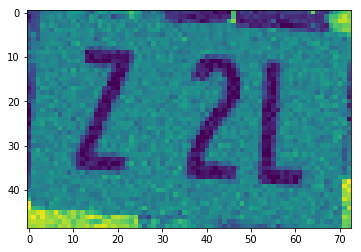

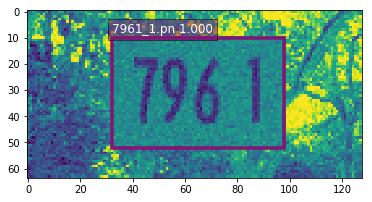

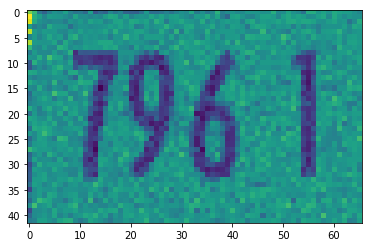

In [9]:
jsons = os.listdir('gen/gen-tags')
classes=['plate']
for i in jsons[0:10]:
    ext = os.path.splitext(i)[-1]
    if ext == '.json':
        jname = str('gen/gen-tags/') + i
        with open(jname, 'r') as jsonfile:  
                readjson = json.load(jsonfile) 
                iname = str('gen/gen-imgs/') + readjson['file']
                img=Image.open(iname)

                rx1=readjson['annotations'][0]['left']
                ry1=readjson['annotations'][0]['top']
                rx2=readjson['annotations'][0]['left']+ readjson['annotations'][0]['width']
                ry2=readjson['annotations'][0]['top']+ readjson['annotations'][0]['height']
                code=readjson['file'][9:18]
                dets = [['0', 1.0, rx1, ry1, rx2, ry2]]
                visualize_detection(img, dets, code)

                cimgname = str('gen/cropped-imgs/') + os.path.splitext(i)[0] + str('.png')
                cropped = Image.open(cimgname)
                plt.imshow(cropped)
                plt.show()

## Check annotation files

* Check the file format of annotation file for object detection

In [10]:
gen_tag = os.listdir('gen/gen-tags')[0]
with open('gen/gen-tags/' + gen_tag, 'r') as jfile:
    print(json.dumps(json.load(jfile), indent=4))

{
    "file": "00000229_LPGG_1.png", 
    "annotations": [
        {
            "class_id": "0", 
            "width": 93, 
            "top": 5, 
            "left": 17, 
            "height": 54
        }
    ], 
    "categories": [
        {
            "class_id": 0, 
            "name": "License Plate"
        }
    ], 
    "image_size": [
        {
            "width": 128, 
            "depth": 3, 
            "height": 64
        }
    ]
}


## Check nums-tags files

* Check the file format of nums-tags file for OCR with CNN
* Real character of license plate can be found with nums index in JOIN list

In [11]:
from common import JOIN

In [12]:
nums_tag = os.listdir('gen/nums-tags')[0]
with open('gen/nums-tags/' + nums_tag, 'r') as jfile:
    n_tag = json.load(jfile)
    print(json.dumps(n_tag, indent=4))

for id in n_tag['nums']: print(JOIN[id]) 

{
    "file": "00000229_LPGG_1.png", 
    "nums": [
        21, 
        25, 
        16, 
        16
    ]
}
L
P
G
G


## Next step
Move to [Lab1](Lab1-custom-object-detection.ipynb) to develop a model to detect license plate area.